<a href="https://colab.research.google.com/github/nidhinraj3/MelanomaDetectionAssignment/blob/main/nidhin_raj_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###<font color='Navy' size='4'><b>Melanoma Detection using CNN</b></font>
<font color='Green' size='3'><u><b>Problem Statement</b></u></font>
<br />
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

###<font color='Navy' size='4'><b>Data Reading/Data Understanding</b></font>
<font color='Green' size='3'><u><b>Defining the path for train and test images<u><b>

In [140]:
#Import Libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [141]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("CNN/Train")
data_dir_test = pathlib.Path('CNN/Test')

In [142]:
#Analyze folders and files

# Print number of image files in each directory of test and train
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Image Count:"+str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Image Count:"+str(image_count_test))

Train Image Count:2239
Test Image Count:118


Total Images Present : 2357
<br/>
Total Images For Training the Model: 2239
<br />
Total Images For Test : 118

In [143]:
#Analyze Output Classes

# Print all subfolders
train_subfolders = [ f.path.replace(str(data_dir_train)+"/","") for f in os.scandir(data_dir_train) if f.is_dir() ]
print(sorted(train_subfolders))
test_subfolders = [ f.path.replace(str(data_dir_test)+"/","") for f in os.scandir(data_dir_test) if f.is_dir() ]
print(sorted(test_subfolders))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


There are 9 subdirectories for each test and train folders for different types of melanoma . <br />
<b>So there are 9 output classes to predict</b>

###<font color='Navy' size='4'><b>Dataset Creation</b></font>
<font color='Green' size='3'><u><b>Create train & validation dataset from the train directory with a batch size of 32 & Resize images to 180*180.<u><b> 

In [144]:
#Create Common Parameters

batch_size = 32
img_height = 180
img_width = 180

In [145]:
#Using a validation split of 80% of the images for training and 20% for validation.
#tf.keras.utils.image_dataset_from_directory utility heps to load data from disk efficiently
#Params:
#   directory - directory to load data from
#   validation_split - Optional float between 0 and 1, fraction of data to reserve for validation. 
#   subset - "Training" means only training dataset is returned
#   seed - 	Optional random seed for shuffling and transformations.
#   image_size - Size to resize images to after they are read from disk
#   batch_size - Size of the batches of data

#Load Train data

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [146]:
#Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


###<font color='Navy' size='4'><b>Dataset Visualization</b></font>
<font color='Green' size='3'><u><b>Visualize one instance of all the nine classes present in the dataset<u><b> 

In [147]:
#print all class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


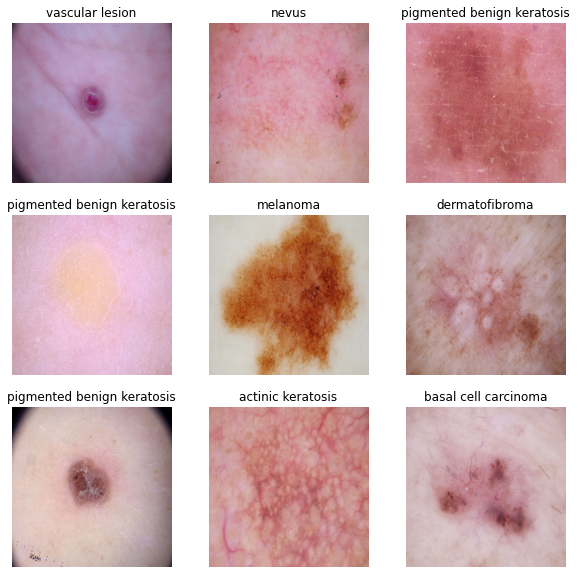

In [148]:
#Visualize images from the training dataset for each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [149]:
#Configure the dataset for performance
#Make sure to use buffered prefetching, to yield data from disk without having I/O become blocking. 
#These are two important methods you should use when loading data:
#       Dataset.cache    - keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training model. 
#       Dataset.prefetch - overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###<font color='Navy' size='4'><b>CNN Model Building & Training</b></font>
<font color='Green' size='3'><u><b>Create Model by applying Rescaling images to normalize pixel values<u><b> 

In [150]:

#Creating a basic Keras Model

#The Keras Sequential model consists of 
#   Three convolution blocks (tf.keras.layers.Conv2D)
#   with a Max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. 
#   There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). 

#Apply rescaling as the first step of the model to standardize images
#RGB channel values are rescaled to be in a standard range of [0,1] to make it suitable for neural networks
#tf.keras.layers.Rescaling utility which is a preprocessing layer which rescales input values to a new range.

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<font color='Green' size='3'><u><b>Compile the model using an Optimizer & Loss function<u><b> 

In [151]:
# Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses. 
# For this assignment, we are choosing the tf.keras.optimizers.Adam optimizer 
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

# The loss function in a neural network quantifies the difference between the expected outcome and the outcome produced by the machine learning model. From the loss function, we can derive the gradients which are used to update the weights. 
# For this assignment we are choosing tf.keras.losses.SparseCategoricalCrossentropy loss function to compute the crossentropy loss between the labels and predictions.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [152]:
#Model Summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)      

<font color='Green' size='3'><u><b>Train the model<u><b> 

In [153]:
#Train the model for 20 epochs with the Keras Model.fit method

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 25ms/step - loss: 2.0849 - accuracy: 0.2121 - val_loss: 1.9305 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 1s 9ms/step - loss: 1.8804 - accuracy: 0.3131 - val_loss: 1.7963 - val_accuracy: 0.3221
Epoch 3/20
56/56 [==============================] - 1s 9ms/step - loss: 1.7507 - accuracy: 0.3672 - val_loss: 1.6379 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 1s 9ms/step - loss: 1.5846 - accuracy: 0.4358 - val_loss: 1.5129 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 1s 9ms/step - loss: 1.5043 - accuracy: 0.4766 - val_loss: 1.6743 - val_accuracy: 0.4295
Epoch 6/20
56/56 [==============================] - 1s 9ms/step - loss: 1.4366 - accuracy: 0.4950 - val_loss: 1.4831 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 1s 9ms/step - loss: 1.3552 - accuracy: 0.5106 - val_loss: 1.4907 - val_accuracy: 0.4855
Epoch 8/20
56/56 [=

<font color='Green' size='3'><u><b>Model Observations<u><b> 

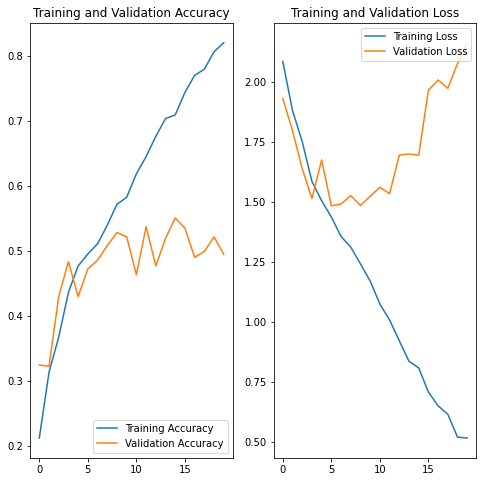

In [154]:
# Plotting of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 55% accuracy on the validation set compared to 85% accuracy on training set</b>

Difference in accuracy between training and validation accuracy is very high , This shows that model is <font color='red'><b>overfitting</b></font>

###<font color='Navy' size='4'><b>Data Augmentation</b></font>
<font color='Green' size='3'><u><b>Handle Underfitting/Overfitting<u><b> 

In [155]:
# Overfitting generally occurs when there are a small number of training examples. 
# Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations

#This can be achieved using keras preprocessors like below
#tf.keras.layers.RandomFlip
#tf.keras.layers.RandomRotation
#tf.keras.layers.RandomZoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

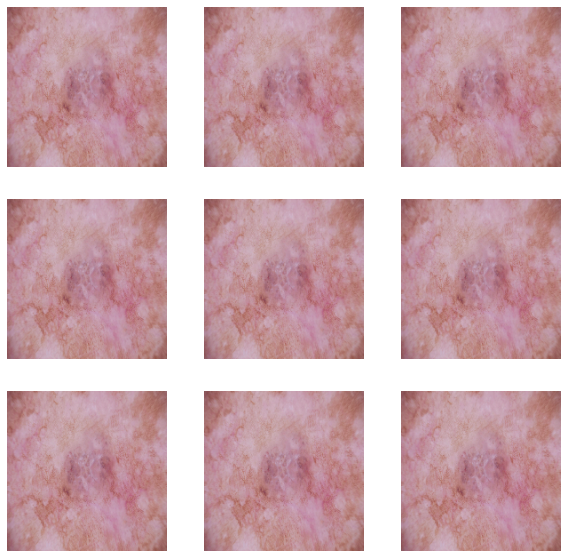

In [156]:
#Previewing augmented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

###<font color='Navy' size='4'><b>CNN Model Building & Training on Augmented Data</b></font>
<font color='Green' size='3'><u><b>Rescale images to normalize pixel values & Add Dropout<u><b> 

In [157]:
# Dropout is another method used to reduce overfitting, When you apply dropout to a layer, 
# it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

<font color='Green' size='3'><u><b>Compile the model using an Optimizer & Loss function<u><b> 

In [158]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [159]:
#Model Summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

<font color='Green' size='3'><u><b>Train the model<u><b> 

In [160]:
#Train the model for 20 epochs with the Keras Model.fit method

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 1.9455 - accuracy: 0.2868 - val_loss: 1.6529 - val_accuracy: 0.4430
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5630 - accuracy: 0.4464 - val_loss: 1.4740 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4586 - accuracy: 0.4883 - val_loss: 1.6724 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4429 - accuracy: 0.4877 - val_loss: 1.4462 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3950 - accuracy: 0.5000 - val_loss: 1.4585 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3547 - accuracy: 0.5123 - val_loss: 1.4270 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3099 - accuracy: 0.5307 - val_loss: 1.3744 - val_accuracy: 0.5391
Epoch 8/20
56

<font color='Green' size='3'><u><b>Model Observations<u><b> 

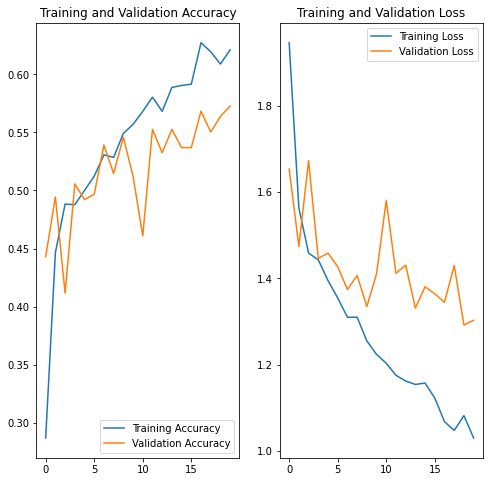

In [161]:
# Plotting of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>Model is now showing similar accuracy in both Training and Validation Sets , although overall accuracy has reduced to around 65%</b><br />
<b> Model is now not overfitting and can be used for prediction <b/>

<font color='Green' size='3'><u><b>Evaluate the Model using Test Data<u><b> 

In [162]:
#Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#Evaluate the model using test data
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(test_acc)

Found 118 files belonging to 9 classes.
4/4 - 1s - loss: 2.6257 - accuracy: 0.3898 - 1s/epoch - 337ms/step
0.38983049988746643


<b>Model evaluation shows around <font color='green'> 38.9%</font> accuracy</b>


###<font color='Navy' size='4'><b>Class distribution</b></font>
<font color='Green' size='3'><u><b>Class Imbalance validation<u><b> 

{'actinic keratosis': 115, 'basal cell carcinoma': 377, 'dermatofibroma': 96, 'melanoma': 439, 'nevus': 358, 'pigmented benign keratosis': 463, 'seborrheic keratosis': 78, 'squamous cell carcinoma': 182, 'vascular lesion': 140}


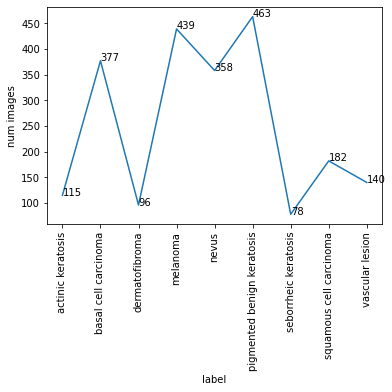

In [163]:
#Writing a function to check class imbaalnc
import glob 

def calc_labels(dirn = None):
    if dirn is None:
        return
    cnts, labels = {}, []
    for label in sorted(os.listdir(f'{dirn}')):
        labels.append(label)
        cnts[label] = len(list(glob.iglob(f'{dirn}' +"/"+label+'/**/**', recursive=True)))
    return cnts, labels
  
#Function to plot counts
def plot_cnts(dirn):
    labels_cnts = calc_labels(dirn)[0]
    print(labels_cnts)
    x, y = zip(*sorted(labels_cnts.items(), key = lambda e: e[0]))
    plt.xlabel('label')
    plt.ylabel('num images')
    plt.plot(x, y)
    for a,b in zip(x, y): 
      plt.text(a, b, str(b))
    plt.xticks(rotation=90)
    plt.show()

plot_cnts(data_dir_train)


<b>Class with the least number of samples:
<br />

<font color='orange'>'seborrheic keratosis': 77 samples</font>

Class dominate the data in terms proportionate number of samples:
<br />
<font color='orange'>'pigmented benign keratosis': 462 samples</font>
</b>

<font color='Green' size='3'><u><b>Handling Class Imbalance<u><b> 

In [164]:
# Using Augmentor library to add more samples across all classes so that none of the classes have very few samples.
# Augmentor is a Python package designed to aid the augmentation and artificial generation of image data for machine learning tasks.

In [165]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [166]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+"/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9945AE3C40>: 100%|██████████| 500/500 [00:03<00:00, 141.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F994495CB50>: 100%|██████████| 500/500 [00:03<00:00, 131.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to CNN/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F99D01720A0>: 100%|██████████| 500/500 [00:04<00:00, 117.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F99DFA98DF0>: 100%|██████████| 500/500 [00:14<00:00, 33.55 Samples/s]


Initialised with 357 image(s) found.
Output directory set to CNN/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F99FA763D00>: 100%|██████████| 500/500 [00:15<00:00, 31.69 Samples/s]


Initialised with 462 image(s) found.
Output directory set to CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9944BA8B20>: 100%|██████████| 500/500 [00:03<00:00, 145.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9944853EB0>: 100%|██████████| 500/500 [00:06<00:00, 72.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9944952E50>: 100%|██████████| 500/500 [00:03<00:00, 134.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F99DF54F670>: 100%|██████████| 500/500 [00:03<00:00, 144.67 Samples/s]


In [167]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


{'actinic keratosis': 1117, 'basal cell carcinoma': 1379, 'dermatofibroma': 1098, 'melanoma': 1441, 'nevus': 1360, 'pigmented benign keratosis': 1465, 'seborrheic keratosis': 1080, 'squamous cell carcinoma': 1184, 'vascular lesion': 1142}


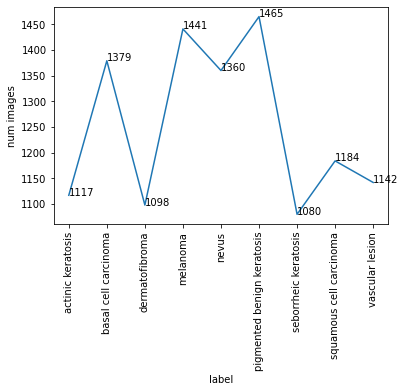

In [168]:
#Check counts after augmenting
plot_cnts(data_dir_train)

###<font color='Navy' size='4'><b>CNN Model Building & Training on Rectified Class Imbalance Data</b></font>
<font color='Green' size='3'><u><b>Reload the data to prepare train and validation dataset<u><b> 

In [169]:
#Using a validation split of 80% of the images for training and 20% for validation.
#tf.keras.utils.image_dataset_from_directory utility heps to load data from disk efficiently
#Params:
#   directory - directory to load data from
#   validation_split - Optional float between 0 and 1, fraction of data to reserve for validation. 
#   subset - "Training" means only training dataset is returned
#   seed - 	Optional random seed for shuffling and transformations.
#   image_size - Size to resize images to after they are read from disk
#   batch_size - Size of the batches of data

#Load Train data

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Configure the dataset for performance
#Make sure to use buffered prefetching, to yield data from disk without having I/O become blocking. 
#These are two important methods you should use when loading data:
#       Dataset.cache    - keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training model. 
#       Dataset.prefetch - overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [170]:
#Apply data augmentation to handle overfitting

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [171]:
#Apply rescaling to standardize and dropout to handle overfitting

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

<font color='Green' size='3'><u><b>Apply Optimizer & Loss function<u><b> 

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [173]:
#Model Summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

<font color='Green' size='3'><u><b>Train the model<u><b> 

In [174]:
#Train the model for 30 epochs with the Keras Model.fit method

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 13s 33ms/step - loss: 1.8415 - accuracy: 0.3062 - val_loss: 1.5468 - val_accuracy: 0.3875
Epoch 2/30
169/169 [==============================] - 4s 23ms/step - loss: 1.4435 - accuracy: 0.4559 - val_loss: 1.3201 - val_accuracy: 0.5137
Epoch 3/30
169/169 [==============================] - 4s 23ms/step - loss: 1.3513 - accuracy: 0.4829 - val_loss: 1.3169 - val_accuracy: 0.5033
Epoch 4/30
169/169 [==============================] - 4s 23ms/step - loss: 1.3008 - accuracy: 0.5106 - val_loss: 1.2574 - val_accuracy: 0.5152
Epoch 5/30
169/169 [==============================] - 4s 23ms/step - loss: 1.2605 - accuracy: 0.5180 - val_loss: 1.2511 - val_accuracy: 0.5219
Epoch 6/30
169/169 [==============================] - 4s 24ms/step - loss: 1.2061 - accuracy: 0.5438 - val_loss: 1.2251 - val_accuracy: 0.5457
Epoch 7/30
169/169 [==============================] - 4s 24ms/step - loss: 1.1520 - accuracy: 0.5623 - val_loss: 1.1001 - val_accuracy: 0.589

<font color='Green' size='3'><u><b>Model Observations<u><b> 

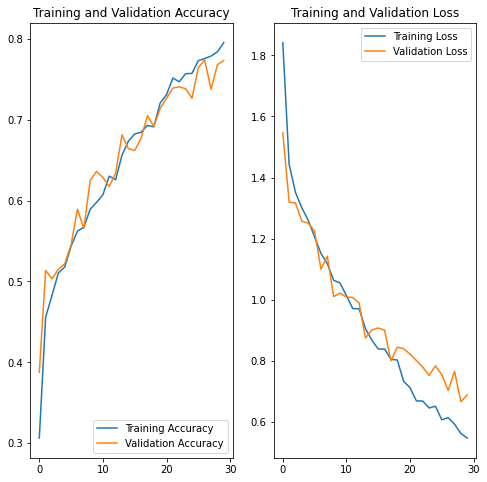

In [175]:
# Plotting of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b> After Applying Class Imbalance / Data Augmentation / Dropout we can see that Traning Accuracy has increased to <font color='green'>80%</font> and model is <font color='green'>not overfitting </font> also as it is performing similar accuracy in case of validation dataset.

<font color='Green' size='3'><u><b>Evaluate the Model using Test Data<u><b> 

In [176]:
#Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#Evaluate the model using test data
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(test_acc)

Found 118 files belonging to 9 classes.
4/4 - 2s - loss: 5.2796 - accuracy: 0.3983 - 2s/epoch - 487ms/step
0.39830508828163147


Test data is now predicted at an accuracy rate of 39.8 %